In [23]:
from ase.units import Hartree
import numpy as np
import matplotlib.pyplot as plt

from mec_sandia.gaussians import discrete_gaussian_wavepacket, _calc_kinetic_energy

In [24]:
def continuous_1d_gaussian(ks, sigma):
    return np.exp(-np.sum(ks**2.0, axis=1)/(2*sigma**2.0))/(np.sqrt(2*np.pi)*sigma)

In [25]:
ecut_ha = 50
ecut_ev = 50 * Hartree
print(f"{ecut_ha} [Ha] = {ecut_ev} [eV]")
box_length = 15
sigma_k = 4
ke_integral = sigma_k**2.0 / 2
kproj = np.array([0])
print(2*np.pi/box_length)

50 [Ha] = 1360.5693012183622 [eV]
0.41887902047863906


There seem to be a few options of where to put the factor of $\Delta k = 2\pi / L$ factor in the definition of the wavepacket. The first is what we've been doing and seems most natural in our context
$$
|\psi \rangle  = \frac{1}{\mathcal{N}_1} \sum_k e^{-k^2/4\sigma_k^2}|k\rangle
$$
we normalize the wavepacket
$$
\langle \psi | \psi \rangle = 1 \rightarrow \mathcal{N}_1 = \sum_k e^{-k^2/2\sigma_k^2}|k\rangle.
$$
To compute a discretization error (sum vs integral) we can use the definitions
$$
\frac{1}{\Delta k}\sum_k \Delta k e^{-k^2/2\sigma_k^2} \rightarrow \frac{1}{\Delta k} \int dk e^{-k^2/2\sigma_k^2} \rightarrow \mathcal{N}_1 \rightarrow \sigma_k \sqrt{2\pi} / \Delta k,
$$
Alternatively we could write
$$
|\psi \rangle  = \frac{1}{\mathcal{N}_2}\sum_k \Delta k \ e^{-k^2/4\sigma_k^2}|k\rangle
$$
then
$$
\mathcal{N}_2 \rightarrow \sigma_k \sqrt{2\pi}\Delta k
$$
or also
$$
|\psi \rangle  = \sum_k \sqrt{\Delta k} \ e^{-k^2/4\sigma_k^2}|k\rangle
$$
then
$$
\mathcal{N}_3 \rightarrow \sigma_k \sqrt{2\pi}
$$

the `discrete_gaussian_wavepacket` takes the first route and does not include any $\Delta k$ factors in the definition of the wavepacket. The `norm` factor returned is $\sum_k e^{-k^2/2\sigma^2}$. When plotting these Gaussian wavepackets we might want to compare to the continuous variant

$$
p(k) = e^{-k^2/2\sigma^2}/\sqrt{2\pi}\sigma\\
\int p(k) dk = 1 
$$

to ensure the discrete version lie on the same line we should divide the probablility distribution $\psi_k^2/\Delta k$, where $\psi_k$ are the amplitudes (returned as `gaussian` below).

3.141592653589793
N1 = 1.7864876819705804, N2 = 31.499219838357778, N3 = 10.026513081625865, integral = 10.026513098524001
1.5707963267948966
N1 = 2.5264750982765665, N2 = 15.749609787287296, N3 = 10.02651299766107, integral = 10.026513098524001
1.0471975511965976
N1 = 3.0942874092564083, N2 = 10.499739789943606, N3 = 10.026512932489103, integral = 10.026513098524001
0.7853981633974483
N1 = 3.5729753297241755, N2 = 7.874804808761601, N3 = 10.026512889585891, integral = 10.026513098524001
0.41887902047863906
N1 = 4.892497963798653, N2 = 4.199895898092338, N3 = 10.02651288979156, integral = 10.026513098524001
0.06283185307179587
N1 = 12.632375419490858, N2 = 0.6299843843208973, N3 = 10.026512883537514, integral = 10.026513098524001


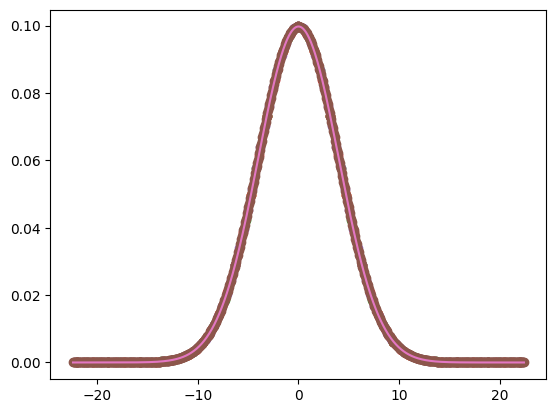

In [26]:
from matplotlib.pyplot import box
ecut = 1000
sigma_k = 4
for bl in [2, 4, 6, 8, 15, 100]:
    gaussian, grid, norm = discrete_gaussian_wavepacket(ecut_hartree=ecut, box_length=bl, sigma=sigma_k, ndim=1)
    dk = 2*np.pi / bl
    print(dk)
    N2 = dk**2.0 * norm**2.0
    N3 = dk * norm**2.0 
    print(f"N1 = {norm}, N2 = {N2}, N3 = {N3}, integral = {sigma_k*np.sqrt(2*np.pi)}")
    plt.plot(grid, gaussian**2.0/dk, marker="o", lw=0)
plt.plot(grid, continuous_1d_gaussian(grid, sigma_k), label="continuous")

The kinetic energy should converge to $\sigma_k$, for a $k_\mathrm{proj}=0$ rapidly with $L$ (grid spacing $\sim 2\pi/L$). Note everything is independently normalized here so it doesn't matter where we put the $\Delta k$ for observables naturally.

In [27]:
from matplotlib.pyplot import box
from mec_sandia.gaussians import kinetic_energy
ecut = 10000
pk = continuous_1d_gaussian(grid, sigma_k)
for bl in [1, 2, 3, 4, 5]:
    dk = 2*np.pi / bl
    ke = kinetic_energy(ecut, bl, sigma_k)
    print(f"L={bl} KE(sum)={ke}, KE(integral) = {sigma_k**2/2} dKE(sum-integral) = {ke-sigma_k**2.0/2}")

L=1 KE(sum)=7.914179146621996, KE(integral) = 8.0 dKE(sum-integral) = -0.08582085337800383
L=2 KE(sum)=7.999999999987032, KE(integral) = 8.0 dKE(sum-integral) = -1.2968293106041529e-11
L=3 KE(sum)=7.999999999999999, KE(integral) = 8.0 dKE(sum-integral) = -8.881784197001252e-16
L=4 KE(sum)=8.0, KE(integral) = 8.0 dKE(sum-integral) = 0.0
L=5 KE(sum)=8.0, KE(integral) = 8.0 dKE(sum-integral) = 0.0


Let's take another look at the dependence on $\sigma_k$

10 3.18460995204194e-05 0.027233115468409588 -0.02720126936888917
10 9.544889534955315e-05 0.027233115468409588 -0.027137666573060035
10 0.00047456868898459526 0.027233115468409588 -0.02675854677942499
10 0.0023956464961162535 0.027233115468409588 -0.024837468972293334
10 0.010057131506801112 0.027233115468409588 -0.017175983961608476
10 0.025369157653650876 0.027233115468409588 -0.0018639578147587113
10 0.02723311309645127 0.027233115468409588 -2.3719583172598924e-09
10 0.027233115468409588 0.027233115468409588 0.0


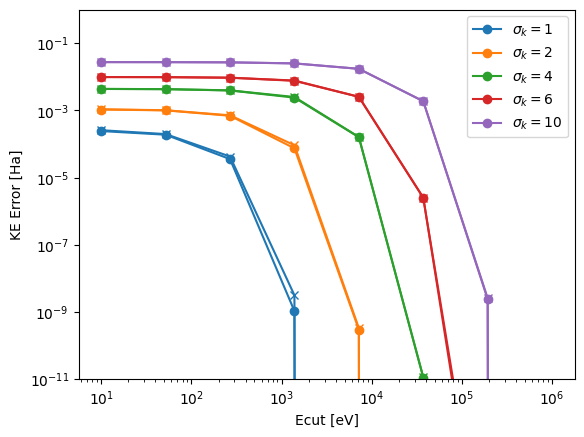

In [28]:
box_length = 15
ecut_ev = np.logspace(1, 6, 8)
mass_proj = 1836
prefactor = 1.0 / mass_proj
from mec_sandia.gaussians import estimate_error_kinetic_energy, kinetic_energy
for isk, sigma_k in enumerate([1, 2, 4, 6, 10]):
    deltas = []
    deltas_approx = []
    for ec in ecut_ev:
        ecut_ha = ec / Hartree
        ke = prefactor*kinetic_energy(ecut_ha, box_length, sigma_k)
        ke_int = prefactor*sigma_k**2/2
        deltas.append(np.abs(ke-ke_int))
        # The factor of 1/2 is because of how we're defining ecut is defined, we
        # only sum from [-nmax/2, nmax/2] which means we should inegrate from
        # [-kmax/2, kmax/2]. (kmax = (2Ecut)^{1/2}) is a spherical cutoff.
        kcut = 0.5*(2*ecut_ha)**0.5
        ke_err_apprx = prefactor*estimate_error_kinetic_energy(kcut, sigma_k)
        deltas_approx.append(ke_err_apprx)
        if sigma_k == 10.0:
            print(sigma_k, ke, ke_int, ke-ke_int)
    plt.plot(ecut_ev, deltas, marker="o", color=f"C{isk}", label=f"$\sigma_k = {sigma_k}$")
    plt.plot(ecut_ev, deltas_approx, marker="x", color=f"C{isk}")
plt.legend()
plt.ylim([1e-11, 1])
plt.xlabel("Ecut [eV]")
plt.ylabel("KE Error [Ha]")
plt.xscale("log")
plt.yscale("log")


10.0 -0.02720126936888917 3.18460995204194e-05 0.027233115468409588
51.794746792312125 -0.027137666573060035 9.544889534955315e-05 0.027233115468409588
268.2695795279727 -0.02675854677942499 0.00047456868898459526 0.027233115468409588
1389.4954943731375 -0.024837468972293334 0.0023956464961162535 0.027233115468409588
7196.856730011521 -0.017175983961608476 0.010057131506801112 0.027233115468409588
37275.93720314938 -0.0018639578147587113 0.025369157653650876 0.027233115468409588
193069.77288832495 -2.3719583172598924e-09 0.02723311309645127 0.027233115468409588
1000000.0 0.0 0.027233115468409588 0.027233115468409588


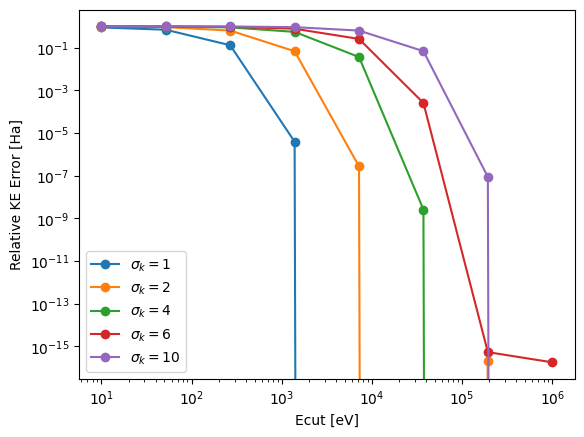

In [29]:
box_length = 15
ecut_ev = np.logspace(1, 6, 8)
mass_proj = 1836
prefactor = 1.0 / mass_proj
from mec_sandia.gaussians import estimate_error_kinetic_energy
for isk, sigma_k in enumerate([1, 2, 4, 6, 10]):
    deltas = []
    deltas_approx = []
    for ec in ecut_ev:
        ecut_ha = ec / Hartree
        ke = prefactor*kinetic_energy(ecut_ha, box_length, sigma_k)
        ke_int = prefactor*sigma_k**2/2
        kcut = 0.5*(2*ecut_ha)**0.5
        ke_err_apprx = prefactor*estimate_error_kinetic_energy(kcut, sigma_k)
        if sigma_k == 10:
            print(ec, ke-ke_int, ke, ke_int)
        deltas.append(np.abs(ke-ke_int)/ke_int)
    plt.plot(ecut_ev, deltas, marker="o", color=f"C{isk}", label=f"$\sigma_k = {sigma_k}$")
    #plt.plot(ecut_ev, deltas_approx, marker="x", color=f"C{isk}")
plt.legend()
#plt.ylim([1e-16, 1e-1])
plt.xlabel("Ecut [eV]")
plt.ylabel("Relative KE Error [Ha]")
plt.xscale("log")
plt.yscale("log")


# Closer look 

Look at

$$
\epsilon = \frac{2}{\sqrt{2\pi}\sigma}
    \int_{k_c}^\infty \frac{k^2}{2} e^{-k^2/2\sigma^2} 
    = \left(\frac{k_c\sigma}{\sqrt{2\pi}} e^{-k_c^2/2\sigma^2} 
    + \frac{1}{2} \sigma^2 \mathrm{erfc}\left(\frac{k_c}{\sqrt{2}\sigma})\right)\right)
$$

In [30]:
import scipy.special
def approx_err(kcut, sigma):
    a = kcut * sigma * np.exp(-kcut**2.0 / (2*sigma**2.0)) / (np.sqrt(2*np.pi))
    b = 0.5 * sigma**2.0 * scipy.special.erfc(kcut/(np.sqrt(2)*sigma))
    return (a + b)


def approx_ke_int(kcut, sigma):
    a = 0.5 * sigma**2.0 * scipy.special.erf(kcut/(np.sqrt(2)*sigma))
    b = kcut * sigma * np.exp(-kcut**2.0/(2*sigma**2.0)) / (np.sqrt(2*np.pi))
    return a - b

$\frac{1}{2} k_c^2 = E_c \rightarrow k_c = \sqrt{2 E_c}$

In [31]:
ecut = 200
kcut = 0.5*(2*ecut)**0.5
sigma_k = 4
print("ke_err old = ", estimate_error_kinetic_energy(kcut, sigma_k))
print("ke_err new = ", approx_err(kcut, sigma_k))
approx_ke = approx_ke_int(kcut, sigma_k)
print("ke_int = ", approx_ke, sigma_k**2.0/2, approx_ke-sigma_k**2.0/2)

ke_err old =  0.7099491125168651
ke_err new =  0.8004866649551597
ke_int =  7.1995133350448395 8.0 -0.8004866649551605


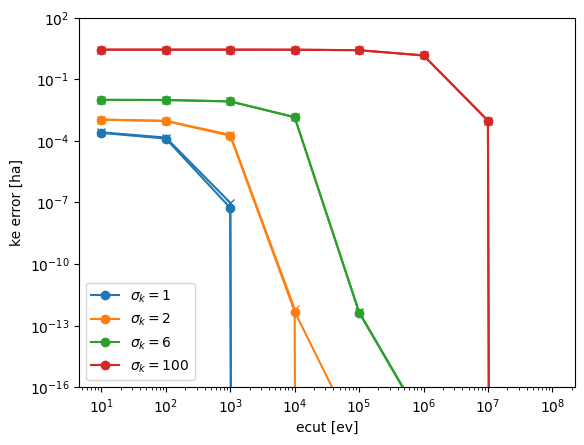

In [32]:

box_length = 15
ecut_ev = np.logspace(1, 8, 8)
mass_proj = 1836
prefactor = 1.0 / mass_proj
delta_k = 2 * np.pi / box_length
from mec_sandia.gaussians import estimate_error_kinetic_energy, kinetic_energy
for isk, sigma_k in enumerate([1, 2, 6, 100]):
    deltas = []
    deltas_approx = []
    for ec in ecut_ev:
        ecut_ha = ec / Hartree
        ke = prefactor*kinetic_energy(ecut_ha, box_length, sigma_k)
        ke_int = prefactor*sigma_k**2/2
        deltas.append(np.abs(ke-ke_int))
        # the factor of 1/2 is because of how we're using ecut, we only sum from
        # [-nmax/2, nmax/2] which means we should inegrate from [-kmax/2,
        # kmax/2]. (kmax = (2ecut)^{1/2}) is a spherical cutoff.
        kcut = 0.5*(2*ecut_ha)**0.5
        ke_err_apprx = prefactor*estimate_error_kinetic_energy(kcut, sigma_k)
        deltas_approx.append(ke_err_apprx)
        # if sigma_k == 10.0:
        #     print(sigma_k, ke, ke_int, ke-ke_int)
    plt.plot(ecut_ev, deltas, marker="o", color=f"C{isk}", label=f"$\sigma_k = {sigma_k}$")
    plt.plot(ecut_ev, deltas_approx, marker="x", color=f"C{isk}")
plt.legend()
plt.ylim([1e-16, 100])
plt.xlabel("ecut [ev]")
plt.ylabel("ke error [ha]")
plt.xscale("log")
plt.yscale("log")


### Bit-Table

In [33]:
import numpy as np
from ase.units import Hartree
box_length = 15
ecut_ev = np.logspace(1, 5, 8)
mass_proj = 1836
prefactor = 1.0 / mass_proj
from mec_sandia.gaussians import estimate_error_kinetic_energy, kinetic_energy, get_ngmax
for isk, sigma_k in enumerate([1, 4, 6, 10]):
    for ec in ecut_ev:
        ecut_ha = ec / Hartree
        nmax = get_ngmax(ecut_ha, box_length)
        ke = prefactor*kinetic_energy(ecut_ha, box_length, sigma_k, ndim=1)
        ke_int = prefactor*sigma_k**2/2
        # The factor of 1/2 is because of how we're using ecut, we only sum from
        # [-nmax/2, nmax/2] which means we should inegrate from [-kmax/2,
        # kmax/2]. (kmax = (2Ecut)^{1/2}) is a spherical cutoff.
        kcut = 0.5*(2*ecut_ha)**0.5
        ke_err_apprx = prefactor*estimate_error_kinetic_energy(kcut, sigma_k)
        if np.abs(ke-ke_int) < 1e-3:
            nbits = np.ceil(np.log2(nmax))
            print(f"{sigma_k} & {ec} & {nmax} & {nbits} & {ke-ke_int} & {ke_err_apprx}")
            break

1 & 10.0 & 3 & 2.0 & -0.0002414205029872535 & 0.00025605621263020804
4 & 7196.856730011514 & 55 & 6.0 & -0.00015861490837127453 & 0.00016099709120250894
6 & 26826.957952797275 & 107 & 7.0 & -2.7257500215727495e-05 & 3.078585019641401e-05
10 & 100000.0 & 205 & 8.0 & -9.25605116709402e-06 & 9.531208035206636e-06


## Effect of the projectile's Kinetic energy shift

The above figure's just looked at the term

$$

2\times\frac{1}{2 m_p \sqrt{2\pi}\sigma} \int_{k_c}^\infty k^2 e^{-k^2/2\sigma^2}

$$

but it is more appropriate to check

$$

2 \times \frac{1}{2 m_p \sqrt{2\pi}\sigma} \int_{k_c}^\infty (k-k_p)^2 e^{-k^2/2\sigma^2}

$$

this can be broken into 3 terms by expanding the square. The first term is what we computed earlier

$$
\frac{1}{\sqrt{2\pi}\sigma}
    \int_{k_c}^\infty k^2 e^{-k^2/2\sigma^2} 
        = \left(\frac{k_c\sigma}{\sqrt{2\pi}} e^{-k_c^2/2\sigma^2} + \frac{1}{2} \sigma^2 \mathrm{erfc}\left(\frac{k_c}{\sqrt{2}\sigma}\right)\right),
$$

and we have two additional terms let's focus on the other two

$$

2 k_p \frac{1}{\sqrt{2\pi}\sigma}\int_{k_c}^\infty dk k e^{-k^2/2\sigma^2} = \frac{2 k_p \sigma}{\sqrt{2\pi}} e^{-k_c^2/2\sigma^2}

$$
and

$$

k_p^2 \frac{1}{\sqrt{2\pi}\sigma}\int_{k_c}^\infty dk e^{-k^2/2\sigma^2} = \frac{k_p^2}{2} \mathrm{erfc}\left(\frac{k_c}{\sqrt{2}\sigma}\right) 

$$

Some limits (the $\mathrm{erfc}(0)=1$): At $k_c=0$, $k_p = 0$ we expect $\epsilon = \frac{\sigma^2}{2 m_p}$ which is just the kinetic energy. Likewise at $k_c=0$, $k_p > 0$ we expect $\epsilon = \frac{(k_p^2 + \sigma^2)}{2 m_p}$, otherwise we expect exponentially fast convergence once $k_c^2 / 2 \sigma^2 > 1$, or $k_c > \sqrt{2} \sigma$

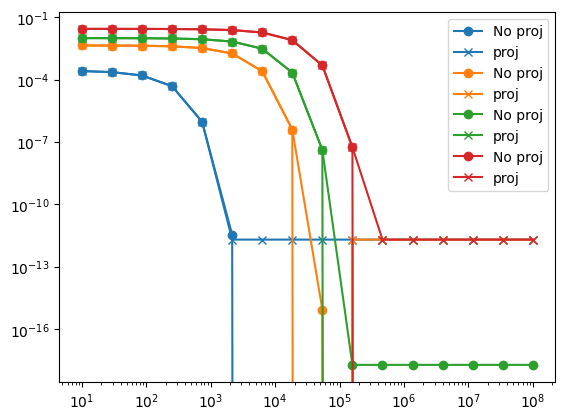

In [34]:
import numpy as np
from ase.units import Hartree
# With the projectiles kinetic energy
from mec_sandia.gaussians import estimate_error_kinetic_energy
import matplotlib.pyplot as plt

ecuts = np.logspace(1, 8, 16)
ndim = 1
v_proj = 4.0
kproj = np.zeros(ndim)
mass_proj = 1836
kproj[0] = mass_proj * v_proj
for ic, sigma in enumerate([1, 4, 6, 10]):
    no_proj = []
    proj = []
    norm = np.sqrt(2*np.pi) * sigma 
    for ec in ecuts:
        kcut = 0.5 * (2*ec/Hartree)**0.5
        ke_err = estimate_error_kinetic_energy(kcut, sigma)
        ke_err_proj = estimate_error_kinetic_energy(kcut, sigma, kproj[0])
        no_proj.append(ke_err/mass_proj)
        proj.append(ke_err_proj/mass_proj)
    plt.plot(ecuts, np.abs(no_proj), marker="o", color=f"C{ic}", label="No proj")
    plt.plot(ecuts, np.abs(proj), marker="x", color=f"C{ic}", label="proj")
plt.yscale("log")
plt.xscale("log")
plt.legend()
# Note that lower precision is observed mainly because we are multiplying very
# large numbers (kproj)**2. The discrete sum shows different behaviour largely
# because of finite size effects (increasing L we see the same plateau in the
# error.) 


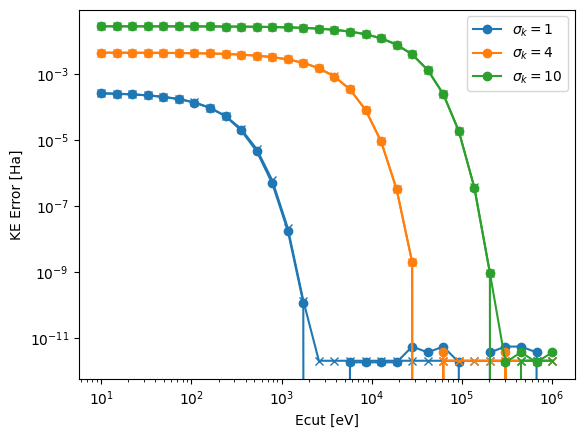

In [35]:
box_length = 100 # Crank up the grid resolution to better approximate the integral expression. 
ecut_ev = np.logspace(1, 6, 30)
mass_proj = 1836
prefactor = 1.0 / mass_proj
ndim = 1
v_proj = 4.0
kproj = np.zeros(ndim)
mass_proj = 1836
kproj[0] = mass_proj * v_proj
from mec_sandia.gaussians import estimate_error_kinetic_energy, kinetic_energy
import scipy.special
delta_k = 2*np.pi / box_length
for isk, sigma_k in enumerate([1, 4, 10]):
    deltas = []
    deltas_approx = []
    for ec in ecut_ev:
        ecut_ha = ec / Hartree
        ke = kinetic_energy(ecut_ha, box_length, sigma_k, kproj=kproj, ndim=ndim)
        ke *= prefactor
        ke_int = prefactor*(sigma_k**2 + np.dot(kproj, kproj)) / 2
        deltas.append(np.abs(ke-ke_int))
        # the factor of 1/2 is because of how we're using ecut, we only sum from
        # [-nmax/2, nmax/2] which means we should inegrate from [-kmax/2,
        # kmax/2]. (kmax = (2ecut)^{1/2}) is a spherical cutoff.
        kcut = 0.5*(2*ecut_ha)**0.5
        ke_err_apprx = estimate_error_kinetic_energy(kcut, sigma_k, kproj=kproj[0])
        ke_err_apprx *= prefactor
        deltas_approx.append(abs(ke_err_apprx))
    plt.plot(ecut_ev, deltas, marker="o", color=f"C{isk}", label=f"$\sigma_k = {sigma_k}$")
    plt.plot(ecut_ev, deltas_approx, marker="x", color=f"C{isk}")
plt.legend()
plt.xlabel("Ecut [eV]")
plt.ylabel("KE Error [Ha]")
plt.xscale("log")
plt.yscale("log")
# Note that lower precision is observed mainly because we are multiplying very
# large numbers (kproj)**2. The discrete sum shows different behaviour largely
# because of finite size effects (increasing L we see the same plateau in the
# error.) 
